# Notebook 5: Logistic Regeression

Here we develop a logistic regression model that makes use of the training data for future prdictions.

In [1]:
#Dependancies and Utilities.
import pandas as pd
import numpy as np
from random import randrange
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
from imblearn.under_sampling import TomekLinks, RandomUnderSampler,NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.metrics import auc,roc_curve,confusion_matrix
from sklearn.linear_model import LogisticRegression

In [12]:
from preprocessCSV import *
from featurize import *

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)
    

## Loading the data
All predictions is to be made using advertiser 1458's training data.

In [15]:
train = pd.read_csv('Data/train_1458.csv')
validate = pd.read_csv('Data/validate_1458.csv')

,Unnamed: 0,day,hour,click,browser,os,ad_exchange,ad_slot_width,ad_slot_height,ad_slot_visibility,ad_slot,ad_slot_floor_price,bidding_price,paying_price,region_id
0,6,3,23,0,ie,windows,3,300,250,0,0,10,300,10,333
1,7,1,15,0,other,windows,1,728,90,2,1,0,300,151,164
2,8,3,10,0,ie,windows,2,728,90,1,0,4,300,183,216
3,11,4,8,0,other,windows,3,300,250,0,0,50,300,70,164
4,15,1,11,0,chrome,windows,3,1000,90,0,0,70,300,70,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617064,2447396,4,18,0,ie,windows,3,300,250,0,0,10,300,20,146
617065,2447403,1,12,0,chrome,windows,3,1000,90,0,0,70,300,70,94
617066,2447406,4,22,0,chrome,windows,3,300,250,0,0,50,300,50,1
617067,2447407,1,21,0,other,windows,1,728,90,1,1,0,300,76,216


In [18]:
#Preprocessing done in notebook 2.
for data in [train, validate]:
    data.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
    data = numerise_features(data)
    data = categorize_features(data,
                               category_features=[
                                   'day', 'hour', 'browser', 'os',
                                   'ad_slot_visibility', 'ad_slot',
                                   'ad_exchange', 'region_id'
                               ])

In [25]:
#Feature Extraction performed in notebook 3.
train = featurise_data(train)
validate = featurise_data(validate)

In [27]:
#Training data overview.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1849308 entries, 0 to 1849307
Data columns (total 100 columns):
 #   Column                  Dtype
---  ------                  -----
 0   click                   int32
 1   ad_slot_width           int32
 2   ad_slot_height          int32
 3   bidding_price           int32
 4   paying_price            int32
 5   day_0                   uint8
 6   day_1                   uint8
 7   day_2                   uint8
 8   day_3                   uint8
 9   day_4                   uint8
 10  day_5                   uint8
 11  day_6                   uint8
 12  hour_0                  uint8
 13  hour_1                  uint8
 14  hour_2                  uint8
 15  hour_3                  uint8
 16  hour_4                  uint8
 17  hour_5                  uint8
 18  hour_6                  uint8
 19  hour_7                  uint8
 20  hour_8                  uint8
 21  hour_9                  uint8
 22  hour_10                 uint8
 23  hour_1

### Class Imbalance

We are handed the task of classifying the the data points into two classes of 'click' and 'not click'. But there is haevy imbalence in the number of training data points avaiable for the two classes. To rectify this the data is downsampled by the following steps. The code is adapted directly from the documnetation of imblearn.

In [31]:
train.groupby(['click']).size()

click
0    1848021
1       1287
dtype: int64

In [32]:
def downsample(data):
    #The imbalanced class.
    data_outlier = data.loc[train['click'] == 1]

    #More weighted class.
    data_inlier = data.loc[data['click'] == 0].sample(
        n=20000, random_state=123).reset_index(drop=True)
    ratio = data_inlier.shape[0]

    data_ = pd.concat([data_inlier, data_outlier], axis=0)

    X = data_.drop(columns=['click', 'paying_price', 'bidding_price'], axis=1)
    X = X.values
    y = data_['click'].values
    sm = SMOTE(sampling_strategy=dict({0: ratio, 1: ratio}))

    X_train, y_train = sm.fit_resample(X, y)

    return X_train, y_train

In [33]:
X_train,y_train = downsample(train)

In [34]:
print(f'Training Data Dimensions:{X_train.shape}')

Training Data Dimensions:(40000, 97)


In [38]:
import collections
collections.Counter(y_train)

Counter({0: 20000, 1: 20000})

As can be seen there are now equal number of training points for both the classes.

---

In [35]:
#Preparing the validation dataset.
X_val = validate.drop(['click', 'paying_price', 'bidding_price'],axis=1).values
y_val = validate['click'].values

---
---

## Finetuning the hyperparameters.

In [40]:
#The parameter space to be searched.
lr_params_grid = {'C': [0.001,0.01,0.1,1.0,10.0,100,1000]}

In [41]:
def tune_hyperparameters(X, y, params_space=lr_params_grid):

    #Defining the model.
    lr_model = LogisticRegression(max_iter=200, verbose=3, n_jobs=-1)
    strk = StratifiedKFold(3, random_state=2048, shuffle=True)

    gr = GridSearchCV(lr_model,
                      params_space,
                      scoring='roc_auc',
                      cv=strk,
                      verbose=3)
    gr.fit(X, y)

    return gr.cv_results_


hyperparams_results = tune_hyperparameters(X=X_train, y=y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   27.4s finished


[CV 1/3] END ........................................C=0.001; total time=  28.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.0s finished


[CV 2/3] END ........................................C=0.001; total time=  14.4s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.4s finished


[CV 3/3] END ........................................C=0.001; total time=   7.7s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.7s finished


[CV 1/3] END .........................................C=0.01; total time=  13.1s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.7s finished


[CV 2/3] END .........................................C=0.01; total time=  12.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.1s finished


[CV 3/3] END .........................................C=0.01; total time=  12.3s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.2s finished


[CV 1/3] END ..........................................C=0.1; total time=  12.4s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV 2/3] END ..........................................C=0.1; total time=  12.2s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.9s finished


[CV 3/3] END ..........................................C=0.1; total time=  11.2s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.9s finished


[CV 1/3] END ..........................................C=1.0; total time=  11.2s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.2s finished


[CV 2/3] END ..........................................C=1.0; total time=  12.6s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.7s finished


[CV 3/3] END ..........................................C=1.0; total time=  11.9s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.0s finished


[CV 1/3] END .........................................C=10.0; total time=  12.3s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.5s finished


[CV 2/3] END .........................................C=10.0; total time=  11.8s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.4s finished


[CV 3/3] END .........................................C=10.0; total time=  11.7s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.4s finished


[CV 1/3] END ..........................................C=100; total time=  11.7s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.6s finished


[CV 2/3] END ..........................................C=100; total time=  11.0s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.5s finished


[CV 3/3] END ..........................................C=100; total time=  11.9s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.9s finished


[CV 1/3] END .........................................C=1000; total time=  13.2s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.5s finished


[CV 2/3] END .........................................C=1000; total time=  12.9s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.3s finished


[CV 3/3] END .........................................C=1000; total time=  14.6s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   23.6s finished


In [42]:
hyperparams_stats_df = pd.DataFrame(hyperparams_results)
hyperparams_stats_df.drop(
    ['params', 'split0_test_score', 'split2_test_score', 'split2_test_score'],
    axis = 1,
    inplace = True)
hyperparams_stats_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,16.819669,8.466498,0.022974,0.022431,0.001,0.879679,0.871866,0.007554,7
1,12.575815,0.434879,0.015573,0.000059,0.01,0.968276,0.966975,0.001444,6
2,12.045636,0.506781,0.015567,0.012759,0.1,0.971033,0.971369,0.001290,2
3,11.984067,0.569993,0.014672,0.006362,1.0,0.973512,0.972225,0.001559,1
4,12.044727,0.261216,0.012506,0.009241,10.0,0.970143,0.969061,0.001102,5
5,11.620989,0.408796,0.000000,0.000000,100,0.969612,0.970201,0.000880,3
6,13.666587,0.763128,0.005166,0.007305,1000,0.970647,0.969612,0.001774,4


**From the table we can conclude that C = 1.0 is the best hyperparameter.**

In [43]:
#Defining the best model.
LR_MODEL = LogisticRegression(C=1.0, max_iter=200, verbose=3, n_jobs=-1)

#Fititng the model over the training dataset and predicting on the validation datset.
y_preds = LR_MODEL.fit(X_train, y_train).predict(X_val)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.7s finished


In [44]:
#Gettting the confusion matrix.
print(confusion_matrix(y_val,y_preds))

[[594866  21763]
 [   406     34]]


In [45]:
#Estimation of pCTR for validation datset.
pred_probs = LR_MODEL.predict_proba(X_val)
pCTR = pd.DataFrame(pred_probs)

C:\Users\Reneeth\anaconda3\envs\R_Data_Analysis\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Logistic Regression pCTR')

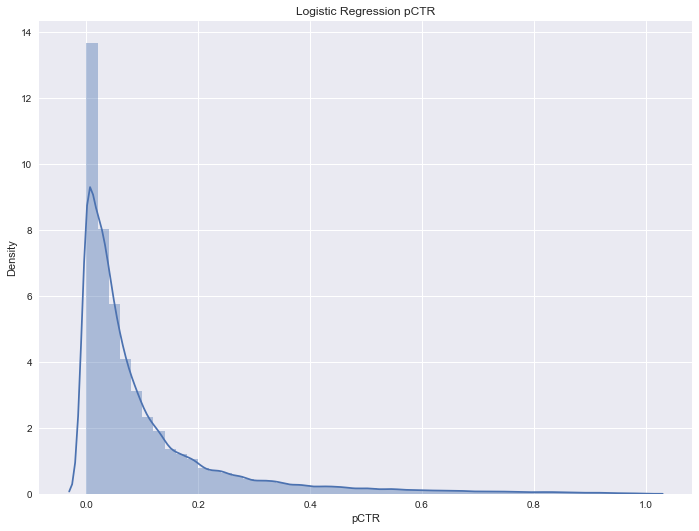

In [46]:
#Defining a figure.
fig,ax = plt.subplots(1,1,figsize=(11.7,8.7))

#pCTR distribution for click=1.
sns.distplot(pCTR[1])
plt.xlabel("pCTR")
plt.title('Logistic Regression pCTR')

In [47]:
#Storing the results.
#pd.DataFrame(pred).to_csv('LR_pCTR_val1.csv')
pCTR[[1]].to_csv('LR_pCTR_val_1458.csv')

In [48]:
LR_pCTR = pd.read_csv('LR_pCTR_val_1458.csv')

In [52]:
#Using a small subset for further verifications.
LR_pCTR = LR_pCTR.loc[:20000,'1']
val_clk = validate.click[:20000]

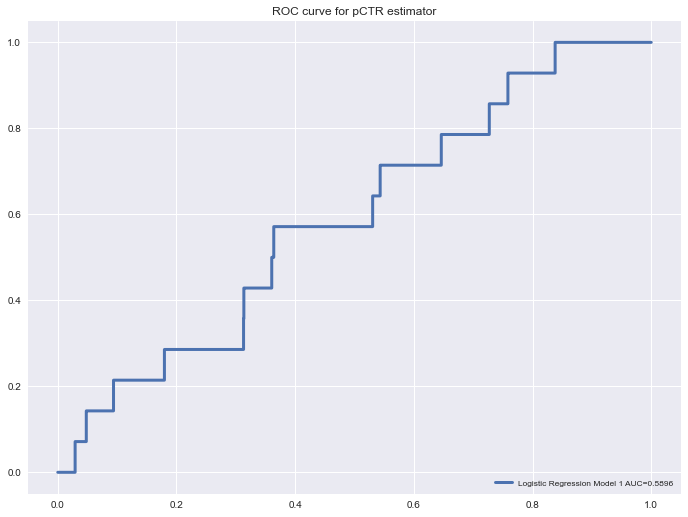

In [55]:
#ROC curves.
rocaucs_list = []

for p_CTR in [LR_pCTR]:
    fpr, tpr, thresholds = roc_curve([click for click in val_clk], p_CTR)
    roc_auc = metrics.auc(fpr, tpr)
    rocaucs_list.append([fpr,tpr,roc_auc])
    
f, axes = plt.subplots(1, figsize=(11.7, 8.7))
for [fpr, tpr, roc_auc],label in zip(rocaucs_list,['Logistic Regression Model 1']):
    lab = '%s AUC=%.4f' % (label,roc_auc)
    axes.step(fpr, tpr, lw=3,label=lab)
axes.legend(loc='lower right', fontsize='small')
plt.title('ROC curve for pCTR estimator')
plt.show()